# Data Generation

#### This notebook contains code for generating dataset using OpenAi APIs

In [ ]:
#!pip install openai ydata-profiling

In [10]:
from openai import OpenAI
import csv
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import random
import re

In [183]:
# client object to send the API request
client = OpenAI(
    api_key="", # the api key from OpenAI
)

In [184]:
#https://github.com/openai/openai-python
# The function to send the prompt message as an API request to the server
def generate_conversation(prompt, max_tokens):
    response = client.chat.completions.create(
        #model="gpt-3.5-turbo",#"is the flagship model of this family, supports a 16K context window and is optimized for dialog."
        model="gpt-4-1106-preview", # the lates gpt-4 model
        messages=prompt,
        max_tokens=max_tokens, # max number of words to be generated
        temperature=0.7
    )
    return response.choices[0].message.content

In [185]:
# to make sure there is a balanced distribution of deceptive participants
categories = ['first participant in conversation is deceiving the second one', 
              'second participant in conversation is deceiving the first one', 
              'both participants in conversation are deceiving each other', 
              'none of participants in conversation try to deceive the other one'
             ]

# Make conversation about differen topics
topics = ['a political subject',
          'a diplomacy subject between european coutries',
          'investing in a business', 
          'buying membership of a club' ,
          'discussing past relationships',
          'a job interview',
          'sale or rental of property',
          'insurance claims after an accident',
          'health issues',
          'friends',
          'family wills and inheritances',
          'travel experiences',
          'cooking tips or recipes' # where one might not fully disclose their secret ingredients or techniques,
         ]

In [202]:
dataset = []
# to monitor how conversation are being generated, this is a small number and this cell will be rerun multiple times
number_of_conversations = 3

for _ in range(number_of_conversations):
    # randomly choose a topic
    topic = random.choice(topics)
    # so in each run 4 conversations will be created 
    for category in categories:
        prompt = [{
            "role": "user",
           "content":f"""Create a long textual conversation about {topic} where {category}.            
            The template should be as follow:
             A: 
             B: 
             and do not use specific names for participants
             and The conversation should be coherent and realistic.
             """
        }]
        # call the generate conversation method
        conversation = generate_conversation(prompt, 3000)  # roughly number of words
        word_count = len(conversation.split())

        if category == 'first participant in conversation is deceiving the second one':
            A_bad_intent = 1
            B_bad_intent = 0
        elif category == 'second participant in conversation is deceiving the first one':
            A_bad_intent = 0
            B_bad_intent = 1
        elif category == 'both participants in conversation are deceiving each other':
            A_bad_intent = 1
            B_bad_intent = 1
        elif  category == 'none of participants in conversation try to deceive the other one':
            A_bad_intent = 0
            B_bad_intent = 0

        print(category)
        print(topic)
        print(conversation)
        print(word_count)

        dataset.append({'category': category,
                        'conversation': conversation , 
                        'word_count' : word_count,
                        'A_bad_intent' : A_bad_intent ,
                        'B_bad_intent' : B_bad_intent,
                        'description' : '',
                        'topic' : topic
                       })


first participant in conversation is deceiving the second one
health issues
A: Hey, I've been hearing a lot about this new health trend that's supposed to be amazing for your wellbeing. Have you heard about it?

B: No, I haven't. What is it?

A: It's this special detox tea that's been all over social media. They say it can help you lose weight, clear up your skin, and give you loads of energy.

B: Sounds interesting, but is it actually effective? I've heard that a lot of these health trends don't really have scientific backing.

A: Trust me, this one is different. I've been using it for a few weeks now, and I feel incredible. The people who make it have loads of testimonials on their website.

B: That's cool, but do you know if there's any actual research on this tea? Testimonials can be misleading sometimes.

A: Well, I'm not sure about formal research, but the ingredients are all natural. It's got stuff like green tea, herbs, and antioxidants. That has to be good for you, right?

B: 

Write data to the file

In [203]:
# save the dataset
with open('conversation_dataset.csv', 'a+', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['category', 'conversation',  'word_count', 'A_bad_intent' , 'B_bad_intent', 'description', 'topic'])
    #writer.writeheader() # this is required only for the first time when creating the file
    writer.writerows(dataset)

Load data from the file

In [6]:
df = pd.read_csv('./data/conversation_dataset.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      200 non-null    object 
 1   conversation  200 non-null    object 
 2   word_count    200 non-null    int64  
 3   A_bad_intent  200 non-null    float64
 4   B_bad_intent  200 non-null    float64
 5   description   15 non-null     object 
 6   topic         92 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 11.1+ KB


In [206]:
df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic
0,first participant in conversation is deceiving...,"A: Hey, I have something really important to t...",437,1.0,0.0,NaN,NaN
1,second participant in conversation is deceivin...,"A: Hey Sarah, I heard you recently went on a t...",368,0.0,1.0,NaN,NaN
2,both participants in conversation are deceivin...,"A: Hey, how have you been? It's been a while s...",400,1.0,1.0,NaN,NaN
3,none of participants in conversation try to de...,A: Hey Sarah! How was your weekend?\n\nB: Hi M...,494,0.0,0.0,NaN,NaN
4,first participant in conversation is deceiving...,A: Hey there! How are you doing today?\n\nB: H...,534,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
195,none of participants in conversation try to de...,A: Hey there! I've been trying to perfect my r...,474,0.0,0.0,NaN,cooking tips or recipes
196,first participant in conversation is deceiving...,"A: Good morning, thank you for having me here ...",542,1.0,0.0,NaN,a job interview
197,second participant in conversation is deceivin...,A: Good afternoon! Thank you for taking the ti...,803,0.0,1.0,NaN,a job interview
198,both participants in conversation are deceivin...,"A: Good morning, and thank you for coming in t...",549,1.0,1.0,NaN,a job interview


---
### Explore data

In [207]:
df['topic'].unique()

array([nan, 'a job interview', 'friends', 'sale or rental of property',
       'family wills and inheritances', 'cooking tips or recipes',
       'insurance claims after an accident', 'travel experiences',
       'discussing past relationships',
       'a diplomacy subject between european coutries', 'health issues'],
      dtype=object)

In [208]:
#ProfileReport(df)

<Axes: ylabel='word_count'>

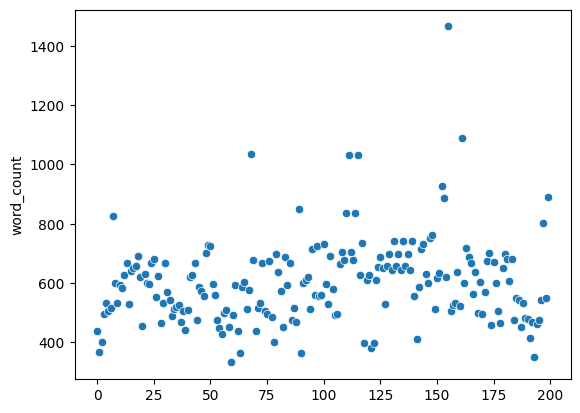

In [209]:
sns.scatterplot(df['word_count'])

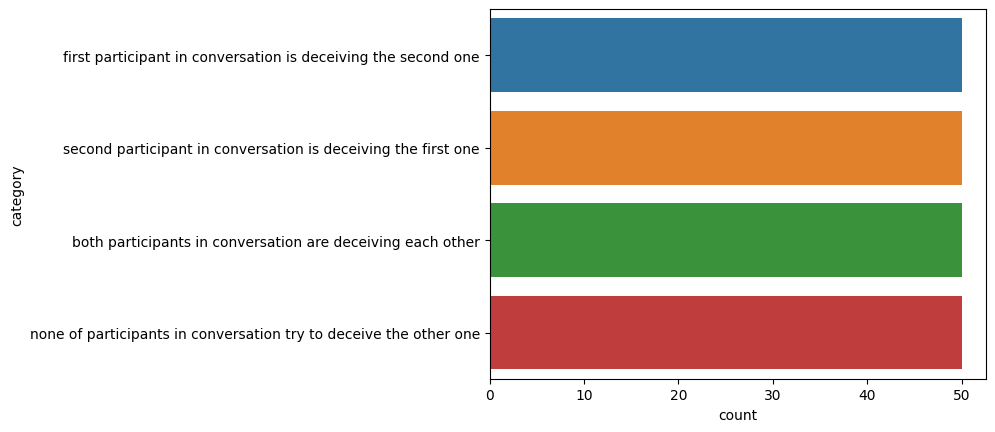

In [210]:
ax = sns.countplot(df, y = 'category')

---
Wordcloud to visualize more frequent words in each category of conversations

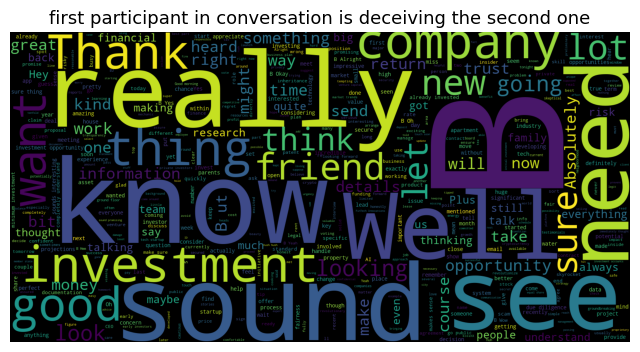

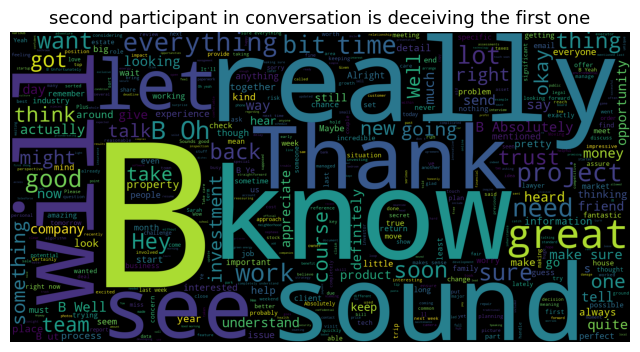

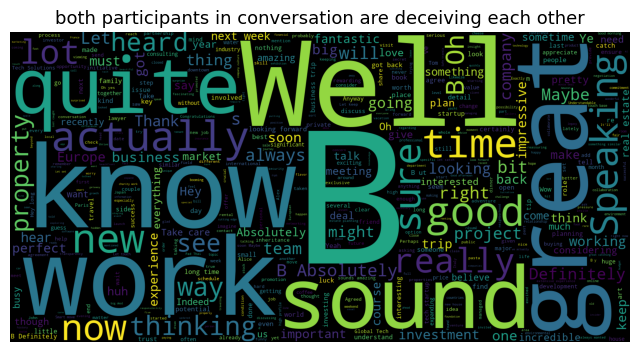

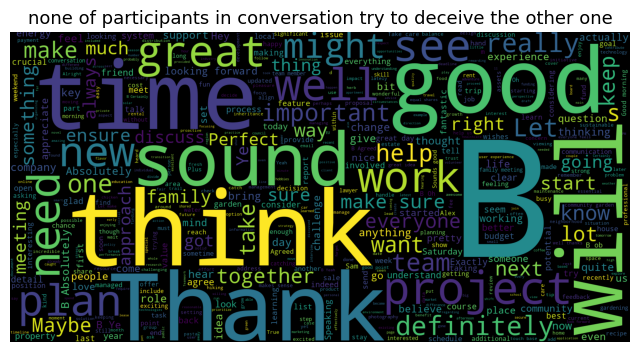

In [211]:
for title in df['category'].unique(): 
    data = df[df['category'] == title]['conversation']
    wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(data))  
    plt.figure(figsize = (8,6))
    plt.axis("off")
    plt.imshow(wc)
    plt.title(title,fontsize=13)
    plt.show()
    plt.close()
    

---
In the wordcloud letter B is very bold, in some conversation b in the middle of text is capital,
like but is B:ut

In [11]:
for i, j in df.iterrows():
    match = pd.Series(j['conversation']).str.contains(r'B:[a-zA-z]').any()
    if  match:  # Check if there was a match
        print('B', i)
    match = pd.Series(j['conversation']).str.contains(r'A:[a-zA-z]').any()
    if  match:  # Check if there was a match
        print('A', i)

B 3
B 4
B 5
B 6
B 7
B 8
B 9
B 10
B 11
B 12
B 13
B 14
B 15
B 16
B 17
B 18
B 19
B 20
B 21
B 22
B 23
B 24
B 25
B 26
B 27
B 28
B 30
B 31
B 32
B 33
B 34
B 35
B 36
B 37
B 38
B 39
B 40
B 41
B 42
B 43
B 44
B 46
B 47
B 49
B 50
B 52
B 53
B 54


In [12]:
# replace B: in the moddle of text 
def replace_pattern(text):
    pattern = r"B:[a-zA-z]"
    return re.sub(pattern, lambda match: match.group().replace("B:", "B"), text)

df['conversation'] = df['conversation'].apply(replace_pattern)

---
Replace specific names or incorrect participant indicators which were generated in first sets of conversations

In [49]:
df['conversation'] = df['conversation'].replace({
    '\*\*A:\*\*': 'A:',
    '\*\*B:\*\*': 'B:',
    'Participant 1': 'A', 
    'Participant 2(\s*\(.*\))?': 'B',
    'Participant A': 'A', 
    'Participant B(\s*\(.*\))?': 'B',
    'Person A': 'A', 
    'Person B(\s*\(.*\))?': 'B',
    'Alice:' : 'A:',
    'John:' : 'B:',
    'Alex:' : 'A:',
    'Jordan:' : 'B:',
    'Taylor:' : 'B:',
    'P1:' : 'A:',
    'P2:' : 'B:',
    'B::' : 'B:'
}, regex=True)

### There are some descriptions at the end of some conversations that must be removed!!!

In [56]:
# extracting the descriptions in parentheses and creating a new column 'description            
for i, j in df.iterrows():
    #if pd.isna(j['description']):
    match = pd.Series(j['conversation']).str.extract(r'\(([^)]+)\)$')
    if not match.isna().all().all():  # Check if there was a match
        df.loc[i,'description'] = match.iloc[0, 0]
    # removing the descriptions from the 'conversation' column
    df.loc[i,'conversation'] = pd.Series(j['conversation']).replace(r'\([^)]+\)$', '', regex=True).iloc[0].strip()  
       

In [64]:
#df['description'].unique().tolist()

In [214]:
df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic
0,first participant in conversation is deceiving...,"A: Hey, I have something really important to t...",437,1.0,0.0,NaN,NaN
1,second participant in conversation is deceivin...,"A: Hey Sarah, I heard you recently went on a t...",368,0.0,1.0,NaN,NaN
2,both participants in conversation are deceivin...,"A: Hey, how have you been? It's been a while s...",400,1.0,1.0,NaN,NaN
3,none of participants in conversation try to de...,A: Hey Sarah! How was your weekend?\n\nB: Hi M...,494,0.0,0.0,NaN,NaN
4,first participant in conversation is deceiving...,A: Hey there! How are you doing today?\n\nB: H...,534,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
195,none of participants in conversation try to de...,A: Hey there! I've been trying to perfect my r...,474,0.0,0.0,NaN,cooking tips or recipes
196,first participant in conversation is deceiving...,"A: Good morning, thank you for having me here ...",542,1.0,0.0,NaN,a job interview
197,second participant in conversation is deceivin...,A: Good afternoon! Thank you for taking the ti...,803,0.0,1.0,NaN,a job interview
198,both participants in conversation are deceivin...,"A: Good morning, and thank you for coming in t...",549,1.0,1.0,NaN,a job interview


---
Remove 'End of conversation' notes from the end of some conversations

In [215]:
df['conversation'] = df['conversation'].str.replace(r'(\(.*\)$|[End of conversation].*$)', '', regex=True).str.strip()

In [ ]:
#print(df.loc[8]['conversation'])

---
Save the cleaned dataset 

In [13]:
df.to_csv('./data/conversation_dataset.csv', index = False)